### Gradient Descent and FISTA

Gradient descent is an iterative algorithm that finds the minimum of a convex function by following the slope "downhill" until it reaches a minimum. To solve the minimization problem
\begin{equation*}
    \operatorname{minimize} g(\mathbf{x}),
\end{equation*}
we find the gradient of $g$ wrt $\mathbf{x}$, $\nabla\mathbf{x} g$, and use the property that the gradient always points in the direction of steepest _ascent_. In order to minimize $g$, we go the other direction:
$$\begin{align*}
    \mathbf{x}_0 &= \text{ initial guess} \\
    \mathbf{x}_{k+1} &\leftarrow \mathbf{x}_k - \alpha_k \nabla g(\mathbf{x}_k),
\end{align*}$$
where $\alpha$ is a step size that determines how far in the descent direction we go at each iteration.

Applied to our problem:
$$\begin{align*}
    g(\boldsymbol  v) &= \frac{1}{2} \|\boldsymbol  A\boldsymbol  v- \boldsymbol  b \|_2^2 \\
    \nabla \boldsymbol  v g(\boldsymbol  v) &= \boldsymbol  A^H (\boldsymbol A\boldsymbol v-\boldsymbol  b),
\end{align*}$$
where $\boldsymbol  A^H$ is the adjoint of $\boldsymbol  A$, $\boldsymbol  b$ is the sensor measurement and $\boldsymbol  v$ is the image of the scene.

We use more efficient variants of this algorithm, like Nesterov Momentum and FISTA, both of which are shown below. 

#### Loading and preparing our images

In [1]:
import numpy as np
import numpy.fft as fft
import matplotlib.pyplot as plt
from IPython import display
from PIL import Image

%matplotlib inline

The code takes in two grayscale images: a point spread function (PSF) $\texttt{psfname}$ and a sensor measurement $\texttt{imgname}$. The images can be downsampled by a factor $f$, which must be a of the form $1/{2^k}$, for some non negative integer $k$ (typically between 1/2 and 1/8). 

In [2]:
psfname = "./psf_sample.tif"
imgname = "./rawdata_hand_sample.tif"

# Downsampling factor (used to shrink images)
f = 1/8 

# Number of iterations
iters = 100

In [3]:
def loaddata(show_im=True):
    psf = Image.open(psfname)
    psf = np.array(psf, dtype='float32')
    data = Image.open(imgname)
    data = np.array(data, dtype='float32')
    
    """In the picamera, there is a non-trivial background 
    (even in the dark) that must be subtracted"""
    bg = np.mean(psf[5:15,5:15]) 
    psf -= bg
    data -= bg
    
    """Resize to a more manageable size to do reconstruction on. 
    Because resizing is downsampling, it is subject to aliasing 
    (artifacts produced by the periodic nature of sampling). Demosaicing is an attempt
    to account for/reduce the aliasing caused. In this application, we do the simplest
    possible demosaicing algorithm: smoothing/blurring the image with a box filter"""
    
    def resize(img, factor):
        num = int(-np.log2(factor))
        for i in range(num):
            img = 0.25*(img[::2,::2,...]+img[1::2,::2,...]+img[::2,1::2,...]+img[1::2,1::2,...])
        return img    
    
    psf = resize(psf, f)
    data = resize(data, f)
    
    
    """Now we normalize the images so they have the same total power. Technically not a
    necessary step, but the optimal hyperparameters are a function of the total power in 
    the PSF (among other things), so it makes sense to standardize it"""
    
    psf /= np.linalg.norm(psf.ravel())
    data /= np.linalg.norm(data.ravel())
    
    if show_im:
        fig1 = plt.figure()
        plt.imshow(psf, cmap='gray')
        plt.title('PSF')
        display.display(fig1)
        fig2 = plt.figure()
        plt.imshow(data, cmap='gray')
        plt.title('Raw data')
        display.display(fig2)
    return psf, data
    

### Calculating convolutions using $\texttt{fft}$
We want to calculate convolutions efficiently. To do this, we use the "fast fourier transform" $\texttt{fft2}$ which computes the Discrete Fourier Transform (DFT). The convolution theorem for DFTs only holds for circular convolutions. We can still recover a linear convolution by first padding the input images then cropping the output of the inverse DFT:
\begin{equation}
    h*x=\mathcal{F}^{-1}[\mathcal{F}[h]\cdot\mathcal{F}[x]] = \texttt{crop}\left[\ \texttt{DFT}^{-1}\left\{\ \texttt{DFT} [\ \texttt{pad}[h]\ ]\cdot\texttt{DFT}[\ \texttt{pad}[x]\ ]\ \right\} \ \right]
\end{equation}

Recovering the linear convolution correctly requires that we double the dimensions of our images. To take full advantage of the speed of the $\texttt{fft2}$ algorithm, we actually pad $\texttt{full\_size}$, which is the nearest power of two that is larger than that size.

We have chosen $\texttt{full\_size}$ in such a way that it provides enough padding to make circular and linear convolutions look the same <i>after being cropped back down to</i> $\texttt{sensor\_size}$. That way, the "sensor crop" due to the sensor's finite size and the "fft crop" above are the same, and we just need one crop function.

Along with initialization, we compute $\texttt{H} = \texttt{fft2}(\texttt{hpad})$ and $\texttt{Hadj} = \texttt{H}^*$, which are constant matrices that will be needed to calculate the action of $\boldsymbol  Q$ and $\boldsymbol  Q^H$ at every iteration. 

Lastly, we must take into account one more practical difference. In imaging, we often treat the center of the image as the origin of the coordinate system. This is theoretically convenient, but fft algorithms assume the origin of the image is the top left pixel. The magnitude of the fft doesn't change because of this distinction, but the phase does, since it is sensitive to shifts in real space. An example with the simplest function, a delta function, is displayed below. In order to correct this problem, we use $\texttt{ifftshift}$ to move the origin of an image to the top left corner and $\texttt{fftshift}$ to move the origin from the top left corner to the center. 

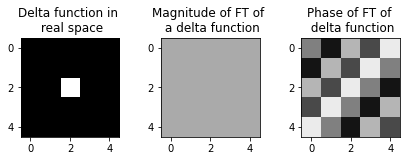

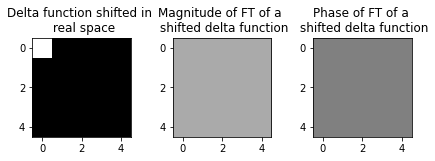

In [4]:
def no_shift():
    delta = np.zeros((5,5))
    delta[2][2] = 1
    fft_mag = np.abs(fft.fft2(delta))
    fft_arg = np.angle(fft.fft2(delta))
    
    fig, ax = plt.subplots(nrows=1, ncols=3)
    fig.tight_layout()
    ax[0].imshow(delta, cmap='gray')
    ax[0].set_title('Delta function in \n real space')

    ax[1].imshow(fft_mag,vmin=-3,vmax=3,cmap='gray')
    ax[1].set_title('Magnitude of FT of \n a delta function')
    
    ax[2].imshow(fft_arg,vmin=-3,vmax=3,cmap='gray')
    ax[2].set_title('Phase of FT of \n delta function')
    
no_shift()   

def shift():
    delta = np.zeros((5,5))
    delta[2][2] = 1
    delta_shifted = fft.ifftshift(delta)
    fft_mag = np.abs(fft.fft2(delta_shifted))
    fft_arg = np.angle(fft.fft2(delta_shifted))
    
    fig2, ax2 = plt.subplots(nrows=1, ncols=3)
    fig2.tight_layout()
    ax2[0].imshow(delta_shifted, cmap='gray')
    ax2[0].set_title('Delta function shifted in \n real space')

    ax2[1].imshow(fft_mag,vmin=-3,vmax=3,cmap='gray')
    ax2[1].set_title('Magnitude of FT of a \n shifted delta function')
    
    ax2[2].imshow(fft_arg,vmin=-3,vmax=3,cmap='gray')
    ax2[2].set_title('Phase of FT of a \n shifted delta function')
    
shift()

For this notebook and the ADMM notebook, we follow the following convention so we don't have to worry about this issue again:
1. All images in _real_ space are stored with the origin in the center (so they can be displayed correctly)
2. All images in _Fourier_ space are stored with the origin in the top left corner (so they can be used for processing correctly)
3. The above rules mean that, to perform a convolution between two real space images $h$ and $x$, we do $$\texttt{fftshift}( \texttt{ifft} [\texttt{fft}[ \texttt{ifftshift}(h) \cdot \texttt{ifftshift}(x) ] ] )$$ instead of $$\texttt{ifft}[\texttt{fft}[h \cdot x]]$$
The rules imply that if we store the fourier transform of $h$ for future use, instead of storing $\texttt{fft}[h]$, we store $\texttt{fft}[\texttt{ifftshift}(h)]$.

In [5]:
def initMatrices(h):
    pixel_start = (np.max(h) + np.min(h))/2
    x = np.ones(h.shape)*pixel_start

    init_shape = h.shape
    padded_shape = [nextPow2(2*n - 1) for n in init_shape]
    starti = (padded_shape[0]- init_shape[0])//2
    endi = starti + init_shape[0]
    startj = (padded_shape[1]//2) - (init_shape[1]//2)
    endj = startj + init_shape[1]
    hpad = np.zeros(padded_shape)
    hpad[starti:endi, startj:endj] = h

    H = fft.fft2(fft.ifftshift(hpad), norm="ortho")
    Hadj = np.conj(H)

    def crop(X):
        return X[starti:endi, startj:endj]

    def pad(v):
        vpad = np.zeros(padded_shape).astype(np.complex64)
        vpad[starti:endi, startj:endj] = v
        return vpad

    utils = [crop, pad]
    v = np.real(pad(x))
    
    return H, Hadj, v, utils

def nextPow2(n):
    return int(2**np.ceil(np.log2(n)))

#### Computing the gradient

The most important step in Gradient Descent is calculating the gradient
$$ \nabla\boldsymbol  v \  g(\boldsymbol  v) = \boldsymbol  A^H (\boldsymbol  A\boldsymbol  v-\boldsymbol  b)$$
We do this in 2 steps:
1. We compute the action of $\boldsymbol  A$ on $\boldsymbol  v$, using $\texttt{calcA}$
2. We compute the action of $\boldsymbol  A^H$ on $\texttt{diff} = \texttt{Av-b}$ using $\texttt{calcAHerm}$ <br/>

Here, $\texttt{vk}$ is the current padded estimate of the scene and $\texttt{b}$ is the sensor measurement.


In [6]:
def grad(Hadj, H, vk, b, crop, pad):
    Av = calcA(H, vk, crop)
    diff = Av - b
    return np.real(calcAHerm(Hadj, diff, pad))

We write $\boldsymbol  A$ as:
$$ \boldsymbol  A\boldsymbol  v \iff \mathrm{crop} \left[ \mathcal{F}^{-1} \left\{\mathcal{F}(h) \cdot \mathcal{F}(v)\right\} \right]$$
In code, this becomes
\begin{align*} 
\texttt{calcA}(\texttt{vk}) & = \texttt{crop}\ (\texttt{ifft}\ (\texttt{fft}(\texttt{hpad}) \cdot \texttt{fft}(\texttt{vk})\ )\  )\\
& = \texttt{crop}\ (\texttt{ifft}\ (\texttt{H} \cdot \texttt{Vk}))
\end{align*}
where $\cdot$ represents point-wise multiplication

In [7]:
def calcA(H, vk, crop):
    Vk = fft.fft2(fft.ifftshift(vk))
    return crop(fft.fftshift(fft.ifft2(H*Vk)))

We first pad $\texttt{diff}$ , giving us $\texttt{xpad}$, then we take the 2D fourier transform, $\texttt{X} = \mathcal{F}(\texttt{xpad})$. The action of the adjoint of $A$ is

$$ A^H \mathbf{x} \iff \mathcal{F}^{-1} \left\{ \mathcal{F}(\boldsymbol  h)^* \cdot \mathcal{F}( \operatorname{pad}\left[x\right]) \right\}$$
This becomes
\begin{align*}
\texttt{calcAHerm}(\texttt{xk}) &= \texttt{ifft}\ (\ (\texttt{fft}(\texttt{h}))^H \cdot \texttt{fft}\ (\texttt{pad}(\texttt{diff}))\ ) \\
& = \texttt{ifft}\ (\texttt{Hadj} \cdot \texttt{X})
\end{align*}

In [8]:
def calcAHerm(Hadj, diff, pad):
    xpad = pad(diff)
    X = fft.fft2(fft.ifftshift(xpad))
    return fft.fftshift(fft.ifft2(Hadj*X))

#### Putting it all together

This is the main function, which calculates the gradients and updates our estimation of the scene:
\begin{align*}
    &\boldsymbol  v_0 = \text{ anything} \\
    &\text{for } k = 0 \text{ to num\_iters:}\\
    &\quad \quad \boldsymbol  v_{k+1} \leftarrow \texttt{gradient\_update}(\boldsymbol  v_k) \\
\end{align*} 

There are different ways of doing the gradient update. The three we will show are regular GD, Nesterov momentum update, and FISTA.

To guarantee convergence, we set the step size to be 
\begin{align*} 
\alpha_k &< \frac{2}{\|\boldsymbol  Q^H \boldsymbol  Q\|}_2 \approx \frac{2}{\lambda_{max}(\mathbf{M}^H\mathbf{M})}
\end{align*}

To calculate this, we use the property that $\mathbf{M}$ is diagonalizable by a Fourier Transform:
$$\begin{align*}
\mathbf{M}^H\mathbf{M} &= \left(\mathbf{F}^{-1} \mathrm{diag}(\mathbf{Fh}) \ \mathbf{F}\right)^H \ \mathbf{F}^{-1} \mathrm{diag}(\mathbf{Fh}) \ \mathbf{F} \\
&= \mathbf{F}^{-1} \mathrm{diag}(\mathbf{Fh})^* \ \mathrm{diag}(\mathbf{Fh}) \ \mathbf{F} \\
\lambda_{max}(\mathbf{M}^H\mathbf{M}) &= \max \left(\mathrm{diag}(\mathbf{Fh})^* \ \mathrm{diag}(\mathbf{Fh}) \right)
\end{align*}$$
In code, we have
\begin{align*}
\alpha = \frac{1.8}{\texttt{max} \left(\texttt{Hadj} \cdot \texttt{H}\right)}
\end{align*}


Since we are dealing with images, one constraint on the reconstructed image $\boldsymbol  v_k$ is that all the entries have to be non-negative. We do this by doing projected gradient descent. The projection function $\texttt{proj}$ we use is non-negativity, which  projects $\texttt{vk}$ onto the non-negative halfspace.  

In [9]:
def grad_descent(h, b):
    H, Hadj, v, utils = initMatrices(h)
    crop = utils[0]
    pad = utils[1]
        
    alpha = np.real(1.8/(np.max(Hadj * H)))
    iterations = 0
     
    def non_neg(xi):
        xi = np.maximum(xi,0)
        return xi
    
    #proj = lambda x:x #Do no projection
    proj = non_neg #Enforce nonnegativity at every gradient step. Comment out as needed.


    parent_var = [H, Hadj, b, crop, pad, alpha, proj]
    
    vk = v
    
    
    
    #### uncomment for Nesterov momentum update ####   
    #p = 0
    #mu = 0.9
    ################################################
    
    
    
    #### uncomment for FISTA update ################
    tk = 1
    xk = v
    ################################################
        
    for iterations in range(iters):   
        
        # uncomment for regular GD update
        #vk = gd_update(vk, parent_var)
        
        # uncomment for Nesterov momentum update 
        #vk, p = nesterov_update(vk, p, mu, parent_var)
        
        # uncomment for FISTA update
        vk, tk, xk = fista_update(vk, tk, xk, parent_var)

        if iterations % 10 == 0:
            image = proj(crop(vk))
            f = plt.figure(1)
            plt.imshow(image, cmap='gray')
            plt.title('Reconstruction after iteration {}'.format(iterations))
            display.display(f)
            display.clear_output(wait=True)
    
    
    return proj(crop(vk)) 
    

#### Gradient descent algorithms

##### Regular Gradient Descent
Regular gradient descent is simply following the negative of the gradient until we reach the minimum:

\begin{align*}
    & \texttt{gradient\_update}(\boldsymbol  v_k): \\
    &\quad \quad\boldsymbol  v'_{k+1} \leftarrow \boldsymbol  v_k - \alpha_k \boldsymbol  A^H(\boldsymbol  A\boldsymbol  v_k - \boldsymbol  b) \\
    &\quad \quad \boldsymbol  v_{k+1} \leftarrow \operatorname{proj}_{\boldsymbol  v \geq 0} (\boldsymbol  v_{k+1}')
\end{align*} 

In [10]:
def gd_update(vk, parent_var):
    H, Hadj, b, crop, pad, alpha, proj = parent_var
    
    gradient = grad(Hadj, H, vk, b, crop, pad)
    vk -= alpha*gradient
    vk = proj(vk)
    
    return xk    

##### Nesterov Momentum
GD works but it's slow. One way to speed it up is to consider a velocity term, $\mathbf{p}$. Each update becomes:

\begin{align*}
    &\texttt{gradient\_update}(\boldsymbol  v_k): \\
    &\qquad \mathbf{p}_{k+1} \leftarrow \mu \mathbf{p}_k - \alpha_k \texttt{grad}(\boldsymbol  v_k) \\
    &\qquad \boldsymbol  v_{k+1}' \leftarrow \boldsymbol  v_k - \mu \mathbf{p}_{k} + (1+\mu)\mathbf{p}_{k+1} \\
    &\qquad \boldsymbol  v_{k+1} \leftarrow \operatorname{proj}_{\boldsymbol  v \geq 0} (\boldsymbol  v_{k+1}')
\end{align*}

The parameter $\mu$ is called the momentum and is strictly between 0 and 1.

In [11]:
def nesterov_update(vk, p, mu, parent_var):
    H, Hadj, b, crop, pad, alpha, proj = parent_var
    
    p_prev = p
    gradient = grad(Hadj, H, vk, b, crop, pad)
    p = mu*p - alpha*gradient
    vk += -mu*p_prev + (1+mu)*p
    vk = proj(vk)
    
    return vk, p

##### FISTA 
Instead of Nesterov momentum, we can use FISTA, which speeds up the iterative process. Each iteration of the algorithm is as follows:

\begin{align*}
    &\texttt{gradient\_update}(\boldsymbol  v_k):\\
    &\qquad \boldsymbol  v_k \leftarrow \boldsymbol  v_k - \alpha_k \texttt{grad}(\boldsymbol  v_k) \\ 
    &\qquad x_{k} \leftarrow \texttt{proj}(\boldsymbol  v_k) \\
    &\qquad t_{k+1} \leftarrow \frac{1+\sqrt{1+4t_k^2}}{2} \\
    &\qquad \boldsymbol  v_{k+1} \leftarrow x_{k} + \frac{t_k-1}{t_{k+1}} (x_{k}-x_{k-1}) \\
\end{align*}


In [12]:
def fista_update(vk, tk, xk, parent_var):
    H, Hadj, b, crop, pad, alpha, proj = parent_var
    
    x_k1 = xk
    gradient = grad(Hadj, H, vk, b, crop, pad)
    vk -= alpha*gradient
    xk = proj(vk)
    t_k1 = (1+np.sqrt(1+4*tk**2))/2
    vk = xk+(tk-1)/t_k1*(xk - x_k1)
    tk = t_k1
    
    return vk, tk, xk

#### Running the algorithm

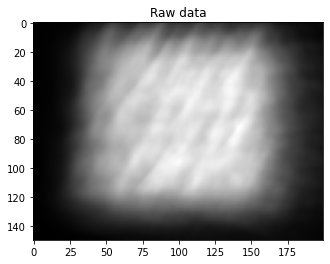

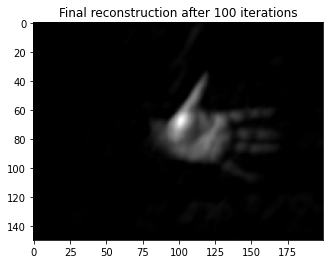

In [13]:
psf, data = loaddata()
final_im = grad_descent(psf, data)
plt.imshow(final_im, cmap='gray')
plt.title('Final reconstruction after {} iterations'.format(iters))
display.display()
